# U-Net Based Spatial Resolution Enhancement for Geospatial Data


by Sudarshan Zunja, 2024

### Project Objective

Geospatial data collected and extracted from various satellites comes with different spatial and temporal resolutions due to factors like varying geographic, environmental and climatic variations. To perform extensive analysis, the data must be available at a higher resolution with clear and precise metrics for various features. The objective of this research is to downscale lower-resolution TROPOMI-SIF data to higher resolution utilizing auxiliary MODIS data. Direct Convolution over features is not sufficient, hence Local Binary Pattern (LBP) is applied to capture local spatial features, overlaying these over SIF data for more accurate results. These features are then passed to the U-Net Model, a type of convolution neural network with encoder-decoder architecture, which performs convolution operations in the encoding-decoding form to learn and predict the target variable at a higher resolution.

### Methodology

SIF data is aggregated at a resolution of 3.5x7 km for 2019 and synthesized using QGIS for spatial and temporal aggregation at 1x1 km resolution. MODIS data is similarly processed, and both datasets are integrated grid-wise for model training. Features are extracted by correlating SIF743 with MODIS indices and employing Local Binary Patterns (LBP) for texture extraction. The final dataset is preprocessed to generate spatial matrices, which are then cropped into smaller segments for input into a multi-channel U-NET model. The U-NET model, comprising 5 Encoder Blocks, a Bottleneck, and 5 Decoder Blocks, is used to upscale the spatial resolution of SIF data, with the architecture tuned for optimal performance.

# Data Used and Curation

Datasource for MODIS-1km-16Day: https://search.earthdata.nasa.gov/search?q=C2565788905-LPCLOUD

Datasource for TROPOSIF-June-2019: https://ftp.sron.nl/open-access-data-2/TROPOMI/tropomi/sif/v2.1/l2b/


Refer to **data_curation.ipynb** for steps on how data is extracted and curated.

**QGIS** is used as the primary geographic information system software for data curation.

Data formats:
        
        TROPOMI_SIF:      **NETCDF format**
        
        MODIS:            **HDF format**

### Import necessary libraries

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Import Integrated SIF-MODIS datasets

In [66]:
seven_data = pd.read_csv('SIF_MODIS_Integrated_7x14km_25_MAY_09_JUNE.csv')
three_data = pd.read_csv('SIF_MODIS_Integrated_3.5x7km_25_MAY_09_JUNE.csv')

secSet_14 = pd.read_csv('SIF_MODIS_Integrated_7x14km_10_JUNE_25_JUNE.csv')
secSet_7 = pd.read_csv('SIF_MODIS_Integrated_3.5x7km_10_JUNE_25_JUNE.csv')

three_data.drop(['fid', 'Window'], axis=1, inplace=True)
secSet_7.drop(['fid'], axis=1, inplace=True)

# seven_data['Window'] = 0
# three_data['Window'] = 0
# secSet_14['Window'] = 1
# secSet_7['Window'] = 1

print(seven_data.shape, three_data.shape, secSet_14.shape, secSet_7.shape)

(16603, 16) (16603, 16) (16586, 16) (16586, 16)


In [67]:
secSet_7.head()

,sif_mean_735,sif_mean_743,longitude,latitude,B_REFL_mean,EVI_mean,MIR_REFL_mean,NDVI_mean,NIR_REFL_mean,PXL_REL_mean,R_REFL_mean,RAA_mean,SZA_mean,VIQ,VZA_mean,COMP_mean
0,0.588446,0.593294,-100.961570,49.762859,461.000000,3111.916667,2015.625000,5034.541667,2713.083333,2.333333,878.652174,743.500000,2922.750000,NaN,2389.250000,169.8
1,0.926404,1.064461,-100.915709,49.762859,491.280000,3049.560000,2066.960000,4851.120000,2745.400000,2.000000,945.000000,-1802.260870,2910.200000,NaN,2645.086957,173.0
2,0.721843,0.925304,-100.823989,49.762859,508.478261,3445.565217,1649.043478,5179.695652,3021.521739,NaN,962.086957,-4736.157895,3004.363636,NaN,2848.863636,NaN
3,0.467859,0.821799,-100.686408,49.762859,472.304348,3197.652174,1445.260870,5135.521739,2729.565217,1.000000,876.826087,4716.888889,2846.166667,NaN,2112.142857,175.0
4,0.777352,1.183632,-100.594687,49.762859,383.040000,3696.920000,1292.333333,5915.000000,2843.880000,1.000000,727.040000,11554.523810,2780.200000,NaN,1844.960000,NaN


In [68]:
three_data.head(5)

,sif_mean_735,sif_mean_743,longitude,latitude,B_REFL_mean,COMP_mean,EVI_mean,MIR_REFL_mean,NDVI_mean,NIR_REFL_mean,PXL_REL_mean,RAA_mean,R_REFL_mean,SZA_mean,VIQ_mean,VZA_mean
0,0.686501,0.883585,-100.502966,49.762859,566.200000,NaN,1904.458333,2100.320000,3345.600000,2201.040000,NaN,12167.791667,1089.480000,2946.625000,NaN,138.560000
1,0.204931,0.312943,-100.457106,49.762859,584.115385,157.0,1561.538462,2351.269231,2888.346154,1983.769231,NaN,11956.240000,1093.884615,2904.818182,NaN,320.160000
2,0.152724,0.336108,-100.365385,49.762859,575.153846,157.0,1640.576923,2441.576923,3011.500000,1999.461538,NaN,11938.363636,1071.615385,2892.363636,NaN,429.739130
3,0.283762,0.278045,-100.319525,49.762859,545.807692,157.0,2041.807692,2213.600000,3622.807692,2189.500000,NaN,11920.720000,1025.269231,2914.250000,NaN,482.960000
4,0.291853,0.370085,-100.273665,49.762859,540.130435,157.0,1786.304348,2583.086957,3345.304348,2002.739130,NaN,12004.000000,1005.434783,2890.888889,NaN,627.772727


### Cross-match (longitude, latitude) values for persistent co-ordinates on either dataset

In [69]:
for idx, row in seven_data.iterrows():
    if row['longitude'] != three_data.loc[idx, 'longitude']:
        print('Longitude mismatch at index:', idx)
    if row['latitude'] != three_data.loc[idx, 'latitude']:
        print('Latitude mismatch at index:', idx)


for idx, row in three_data.iterrows():
    if row['longitude'] != seven_data.loc[idx, 'longitude']:
        print('Longitude mismatch at index:', idx)
    if row['latitude'] != seven_data.loc[idx, 'latitude']:
        print('Latitude mismatch at index:', idx)

for idx, row in secSet_14.iterrows():
    if row['longitude'] != secSet_7.loc[idx, 'longitude']:
        print('Longitude mismatch at index:', idx)
    if row['latitude'] != secSet_7.loc[idx, 'latitude']:
        print('Latitude mismatch at index:', idx)


for idx, row in secSet_7.iterrows():
    if row['longitude'] != secSet_14.loc[idx, 'longitude']:
        print('Longitude mismatch at index:', idx)
    if row['latitude'] != secSet_14.loc[idx, 'latitude']:
        print('Latitude mismatch at index:', idx)

### Dealing with NaN values

In [70]:
# print(np.isnan(secSet_14).any())
secSet_14['EVI_mean'].fillna(0, inplace=True)
secSet_14['NDVI_mean'].fillna(0, inplace=True)
secSet_14['NIR_REFL_mean'].fillna(0, inplace=True)
secSet_14['RAA_mean'].fillna(0, inplace=True)
secSet_14['VZA_mean'].fillna(0, inplace=True)
print(np.isnan(secSet_14).any())

# print(np.isnan(secSet_7).any())
secSet_7['B_REFL_mean'].fillna(0, inplace=True)
secSet_7['EVI_mean'].fillna(0, inplace=True)
secSet_7['MIR_REFL_mean'].fillna(0, inplace=True)
secSet_7['NDVI_mean'].fillna(0, inplace=True)
secSet_7['NIR_REFL_mean'].fillna(0, inplace=True)
secSet_7['PXL_REL_mean'].fillna(0, inplace=True)
secSet_7['NDVI_mean'].fillna(0, inplace=True)
secSet_7['R_REFL_mean'].fillna(0, inplace=True)
secSet_7['RAA_mean'].fillna(0, inplace=True)
secSet_7['SZA_mean'].fillna(0, inplace=True)
secSet_7['VIQ'].fillna(0, inplace=True)
secSet_7['VZA_mean'].fillna(0, inplace=True)
secSet_7['COMP_mean'].fillna(0, inplace=True)
print(np.isnan(secSet_7).any())

longitude        False
latitude         False
sif_mean_735     False
sif_mean_743     False
B_REFL_mean      False
COMP_mean        False
EVI_mean         False
MIR_REFL_mean    False
NDVI_mean        False
NIR_REFL_mean    False
PXL_REL_mean     False
R_REFL_mean      False
RAA_mean         False
SZA_mean         False
VIQ_mean         False
VZA_mean         False
dtype: bool
sif_mean_735     False
sif_mean_743     False
longitude        False
latitude         False
B_REFL_mean      False
EVI_mean         False
MIR_REFL_mean    False
NDVI_mean        False
NIR_REFL_mean    False
PXL_REL_mean     False
R_REFL_mean      False
RAA_mean         False
SZA_mean         False
VIQ              False
VZA_mean         False
COMP_mean        False
dtype: bool


C:\Users\sudar\AppData\Local\Temp\ipykernel_4600\486803294.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  secSet_14['EVI_mean'].fillna(0, inplace=True)
C:\Users\sudar\AppData\Local\Temp\ipykernel_4600\486803294.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [71]:
# print(np.isnan(seven_data).any())
seven_data['COMP_mean'].fillna(0, inplace=True)
seven_data['PXL_REL_mean'].fillna(0, inplace=True)
seven_data['VIQ_mean'].fillna(0, inplace=True)
print(np.isnan(seven_data).any())

# print(np.isnan(three_data).any())
three_data['COMP_mean'].fillna(0, inplace=True)
three_data['PXL_REL_mean'].fillna(0, inplace=True)
three_data['VIQ_mean'].fillna(0, inplace=True)
print(np.isnan(three_data).any())

longitude        False
latitude         False
sif_mean_735     False
sif_mean_743     False
B_REFL_mean      False
COMP_mean        False
EVI_mean         False
MIR_REFL_mean    False
NDVI_mean        False
NIR_REFL_mean    False
PXL_REL_mean     False
RAA_mean         False
R_REFL_mean      False
SZA_mean         False
VIQ_mean         False
VZA_mean         False
dtype: bool
sif_mean_735     False
sif_mean_743     False
longitude        False
latitude         False
B_REFL_mean      False
COMP_mean        False
EVI_mean         False
MIR_REFL_mean    False
NDVI_mean        False
NIR_REFL_mean    False
PXL_REL_mean     False
RAA_mean         False
R_REFL_mean      False
SZA_mean         False
VIQ_mean         False
VZA_mean         False
dtype: bool


C:\Users\sudar\AppData\Local\Temp\ipykernel_4600\1473525218.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  seven_data['COMP_mean'].fillna(0, inplace=True)
C:\Users\sudar\AppData\Local\Temp\ipykernel_4600\1473525218.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### Plot Correlation Matrix, considering sif_743 as target variable


<AxesSubplot: title={'center': 'Correlation Matrix for SIF-MODIS_1 for 7x14 km'}>

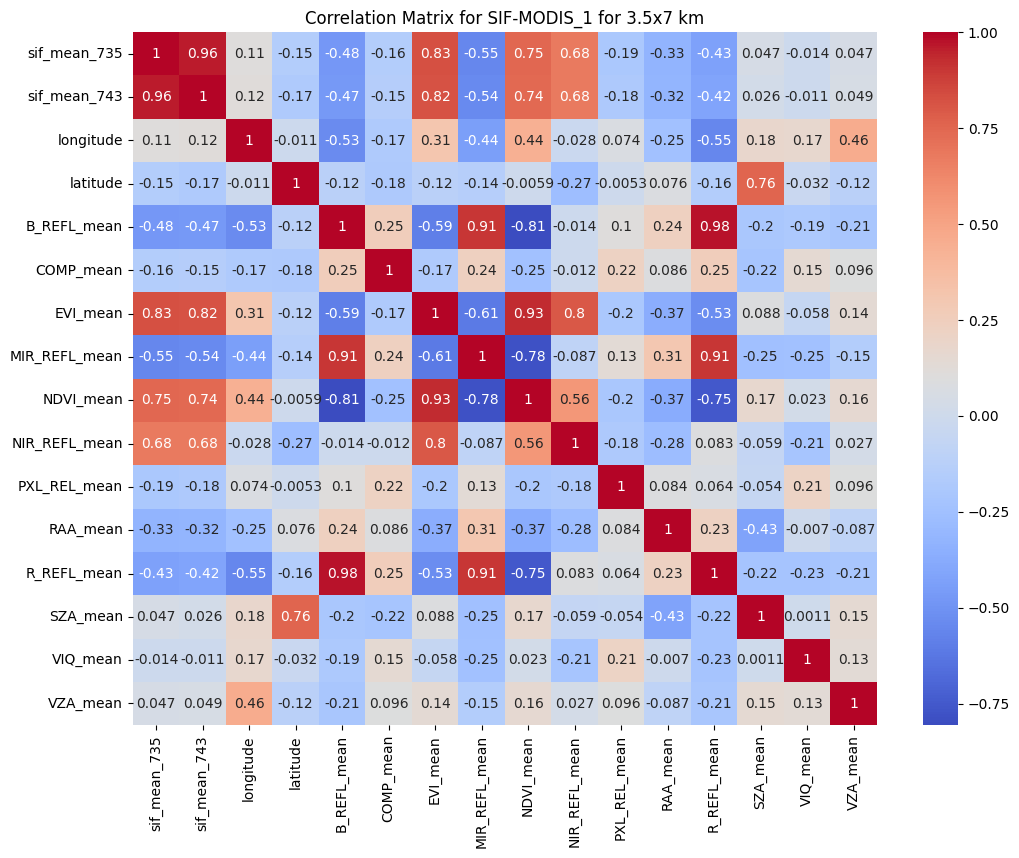

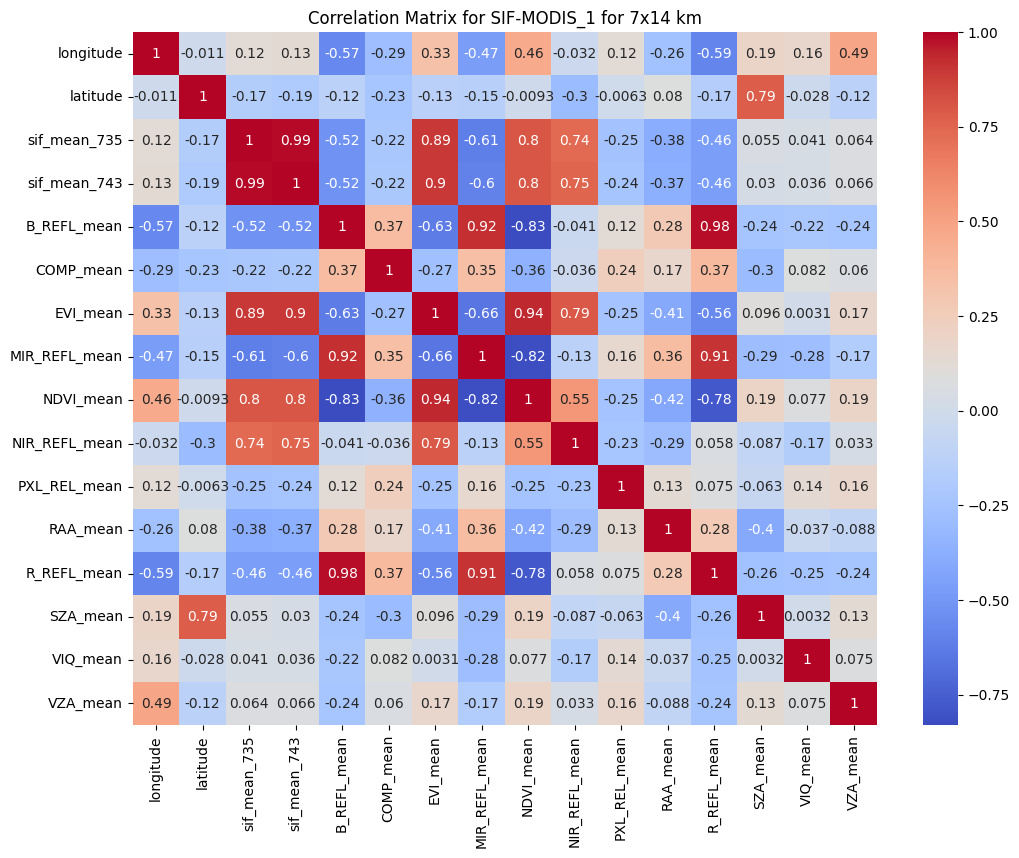

In [72]:
corr = three_data.corr()

plt.figure(figsize=(12, 9))
plt.title('Correlation Matrix for SIF-MODIS_1 for 3.5x7 km')
sns.heatmap(corr, cmap='coolwarm', annot=True)

corr = seven_data.corr()

plt.figure(figsize=(12, 9))
plt.title('Correlation Matrix for SIF-MODIS_1 for 7x14 km')
sns.heatmap(corr, cmap='coolwarm', annot=True)

<AxesSubplot: title={'center': 'Correlation Matrix for SIF-MODIS_2 for 7x14 km'}>

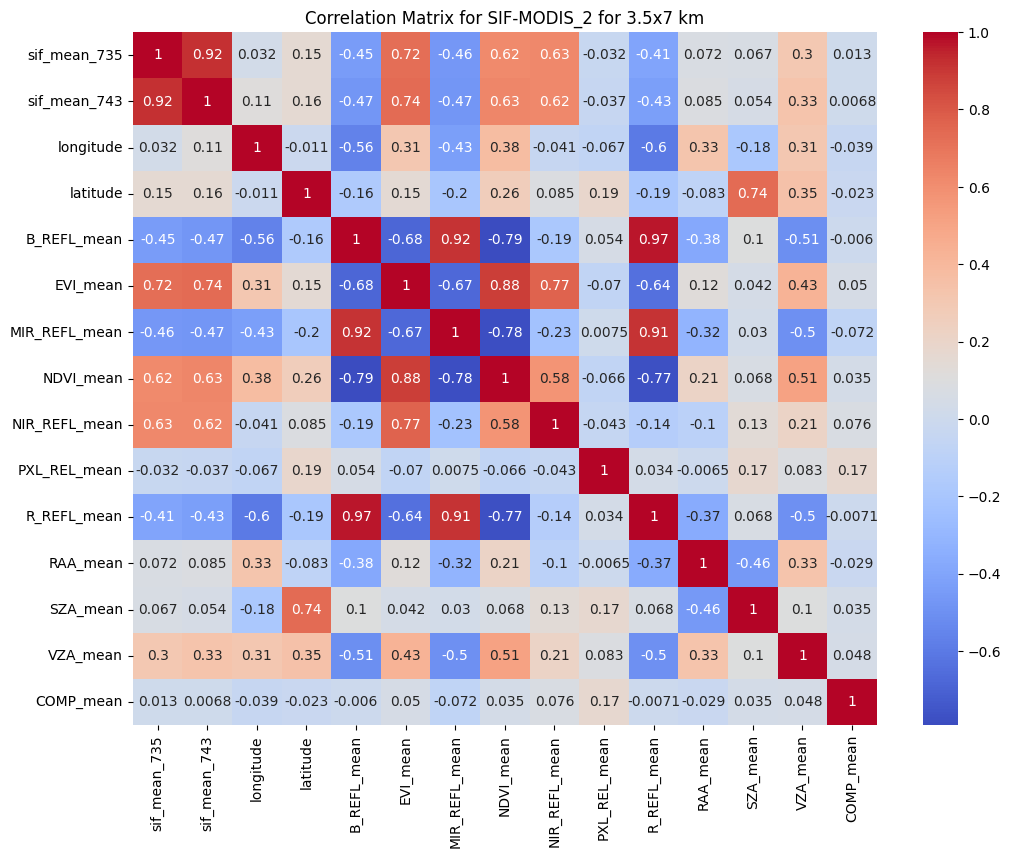

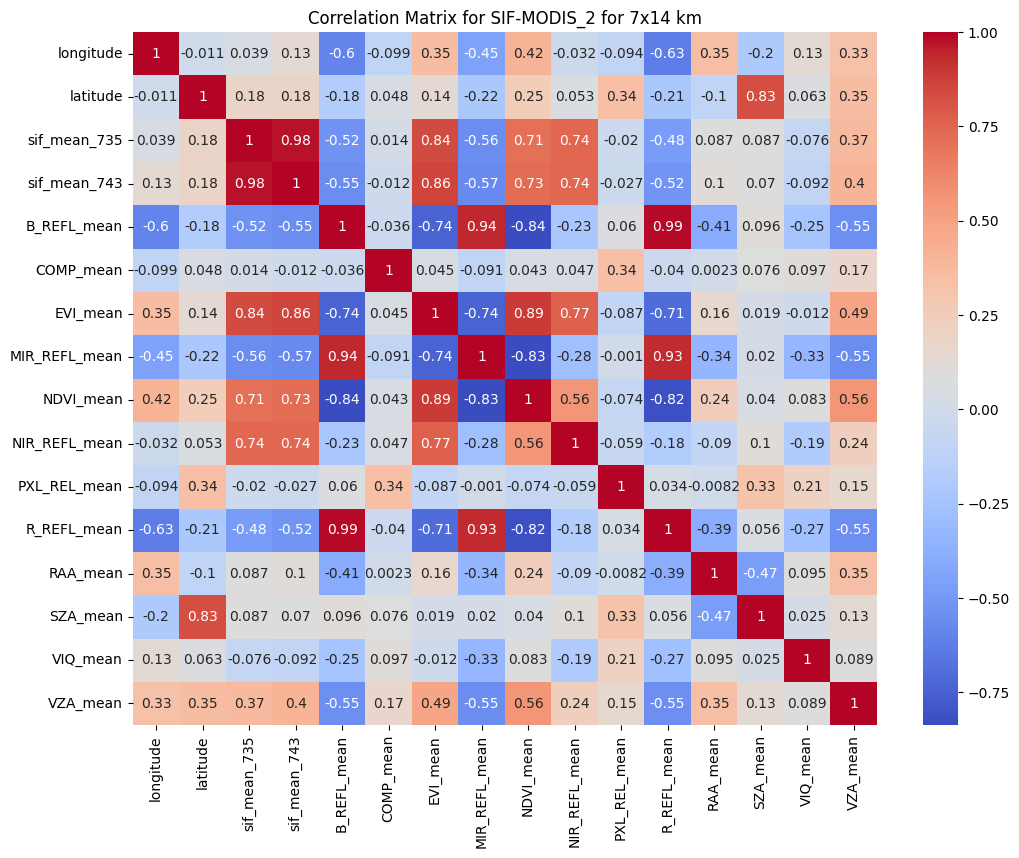

In [73]:
secSet_7= secSet_7.drop(['VIQ'], axis=1)
corr = secSet_7.corr()
plt.figure(figsize=(12, 9))
plt.title('Correlation Matrix for SIF-MODIS_2 for 3.5x7 km')
sns.heatmap(corr, cmap='coolwarm', annot=True)

corr = secSet_14.corr()
plt.figure(figsize=(12, 9))
plt.title('Correlation Matrix for SIF-MODIS_2 for 7x14 km')
sns.heatmap(corr, cmap='coolwarm', annot=True)

### Merge Features

In [74]:
merged = []
merged = {
    'longitude': seven_data['longitude'].copy(),
    'latitude': seven_data['latitude'].copy(),
    'sif_743': seven_data['sif_mean_743'].copy(),
    'NDVI': seven_data['NDVI_mean'].copy(),
    'EVI': seven_data['EVI_mean'].copy(),
    'NIR': seven_data['NIR_REFL_mean'].copy(),
    'target_sif': three_data['sif_mean_743'].copy()
}

merged_df = pd.DataFrame(merged)
print(merged_df.head(5))


merged_2 = []
merged_2 = {
    'longitude': secSet_14['longitude'].copy(),
    'latitude': secSet_14['latitude'].copy(),
    'sif_743': secSet_14['sif_mean_743'].copy(),
    'NDVI': secSet_14['NDVI_mean'].copy(),
    'EVI': secSet_14['EVI_mean'].copy(),
    'NIR': secSet_14['NIR_REFL_mean'].copy(),
    'target_sif': secSet_7['sif_mean_743'].copy()
}

merged_2_df = pd.DataFrame(merged_2)
print(merged_2_df.head(5))

    longitude   latitude   sif_743         NDVI          EVI          NIR  \
0 -100.502966  49.762859  0.691817  3972.114286  2281.788462  2287.819048   
1 -100.457106  49.762859  0.548354  3349.292453  1896.943396  2156.669811   
2 -100.365385  49.762859  0.333582  3063.990476  1692.438095  2054.323810   
3 -100.319525  49.762859  0.323240  3195.285714  1743.542857  2036.304762   
4 -100.273665  49.762859  0.294832  3379.736364  1842.990909  2069.290909   

   target_sif  
0    0.883585  
1    0.312943  
2    0.336108  
3    0.278045  
4    0.370085  
    longitude   latitude   sif_743         NDVI          EVI          NIR  \
0 -100.961570  49.762859  1.010215  4487.916667  2786.916667  2643.025641   
1 -100.915709  49.762859  0.847016  4590.670807  2867.391304  2673.391304   
2 -100.823989  49.762859  0.772814  5105.980769  3325.929487  2897.762821   
3 -100.686408  49.762859  0.897437  5342.127389  3397.160256  2833.243590   
4 -100.594687  49.762859  1.161502  5681.215190  3558.57

In [75]:
print(merged_df.shape, merged_2_df.shape)

(16603, 7) (16586, 7)


In [76]:
print(np.isnan(merged_2_df).any())

longitude     False
latitude      False
sif_743       False
NDVI          False
EVI           False
NIR           False
target_sif    False
dtype: bool


In [77]:
test_three_data = []
test_three_data = {
    'longitude': three_data['longitude'].copy(),
    'latitude': three_data['latitude'].copy(),
    'sif_743': three_data['sif_mean_743'].copy(),
    'NDVI': three_data['NDVI_mean'].copy(),
    'EVI': three_data['EVI_mean'].copy(),
    'NIR': three_data['NIR_REFL_mean'].copy(),
}

test_three_df = pd.DataFrame(test_three_data)
test_three_df.head(5)

In [78]:
merged_df.sample(frac=1, ignore_index=True)
merged_2_df.sample(frac=1, ignore_index=True)
# test_three_df.sample(frac=1, ignore_index=True)

,longitude,latitude,sif_743,NDVI,EVI,NIR,target_sif
0,-99.448178,45.738425,1.027025,4934.962264,2991.301887,2634.201258,0.706688
1,-97.797206,47.247588,0.427341,3483.535484,2007.838710,2207.307190,0.459892
2,-93.486333,43.726208,0.602784,5505.000000,2572.788321,2067.090909,0.637861
3,-95.733490,45.801307,0.897973,4561.363057,2753.006369,2516.465116,0.726341
4,-99.264737,43.726208,1.279746,5147.043478,3348.751553,2852.322981,1.121571
...,...,...,...,...,...,...,...
16581,-94.495261,48.190815,0.911688,6660.912752,3537.133333,2196.946667,0.806112
16582,-99.081296,48.505223,0.884810,4355.388158,2492.342105,2321.337748,1.268102
16583,-94.403540,47.750642,2.030412,8686.105960,5834.176471,3506.644737,1.819506
16584,-95.320747,47.813524,1.848424,7968.960784,4960.124183,3041.947712,1.507005


In [79]:
from sklearn.preprocessing import StandardScaler

merged_df['diff_sif'] = merged_df['target_sif'] - merged_df['sif_743']
input_scaled_df = merged_df[['sif_743', 'NDVI', 'EVI', 'NIR', 'target_sif', 'diff_sif']]
print(input_scaled_df.head(5))

merged_2_df['diff_sif'] = merged_2_df['target_sif'] - merged_2_df['sif_743']
input_scaled_2_df = merged_2_df[['sif_743', 'NDVI', 'EVI', 'NIR', 'target_sif', 'diff_sif']]
print(input_scaled_2_df.head(5))

    sif_743         NDVI          EVI          NIR  target_sif  diff_sif
0  0.691817  3972.114286  2281.788462  2287.819048    0.883585  0.191768
1  0.548354  3349.292453  1896.943396  2156.669811    0.312943 -0.235411
2  0.333582  3063.990476  1692.438095  2054.323810    0.336108  0.002526
3  0.323240  3195.285714  1743.542857  2036.304762    0.278045 -0.045195
4  0.294832  3379.736364  1842.990909  2069.290909    0.370085  0.075253
    sif_743         NDVI          EVI          NIR  target_sif  diff_sif
0  1.010215  4487.916667  2786.916667  2643.025641    0.593294 -0.416921
1  0.847016  4590.670807  2867.391304  2673.391304    1.064461  0.217445
2  0.772814  5105.980769  3325.929487  2897.762821    0.925304  0.152490
3  0.897437  5342.127389  3397.160256  2833.243590    0.821799 -0.075638
4  1.161502  5681.215190  3558.579618  2836.341772    1.183632  0.022130


In [80]:
print(np.isnan(input_scaled_2_df).any())


sif_743       False
NDVI          False
EVI           False
NIR           False
target_sif    False
diff_sif      False
dtype: bool


In [82]:
print(secSet_14['latitude'][5800], secSet_7['latitude'][5800])

45.6755432627 45.6755432627


In [83]:
print(np.isnan(seven_data).any())

longitude        False
latitude         False
sif_mean_735     False
sif_mean_743     False
B_REFL_mean      False
COMP_mean        False
EVI_mean         False
MIR_REFL_mean    False
NDVI_mean        False
NIR_REFL_mean    False
PXL_REL_mean     False
RAA_mean         False
R_REFL_mean      False
SZA_mean         False
VIQ_mean         False
VZA_mean         False
dtype: bool


### Implement Local Binary Pattern for Texture Extraction and Localization

In [ ]:
#  We implement Local Binary Pattern to localize features over the auxiliary data. This will help in capturing input sif_743
#  which is spread over different temporal timeframe to map features over consistent auxiliary data.
#  It will also help to preserve neighbourhood connections and will help in gap-filling tasks.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def lbp(image, P=8, R=1):
    """Compute Local Binary Pattern (LBP) of an image."""
    # Convert image to uint8 if necessary
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    lbp_image = np.zeros_like(image, dtype=np.uint8)
    height, width = image.shape

    # Define the offsets for the neighborhood pixels
    offsets = [(0, R), (R, R), (R, 0), (R, -R),
               (0, -R), (-R, -R), (-R, 0), (-R, R)]

    for i in range(height):
        for j in range(width):
            center = image[i, j]
            binary_code = 0
            for k, (y_off, x_off) in enumerate(offsets):
                y, x = i + y_off, j + x_off
                if 0 <= y < height and 0 <= x < width:
                    binary_code |= (image[y, x] > center) << k
            lbp_image[i, j] = binary_code

    return lbp_image

### Convert features into geospatial matrix using lat, long coordinates, including LBP and sif_diff. Generate required submatrices by cropping, augmenting features matrices.

C:\Users\sudar\AppData\Local\Temp\ipykernel_4600\2950252498.py:9: RuntimeWarning: invalid value encountered in cast
  image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


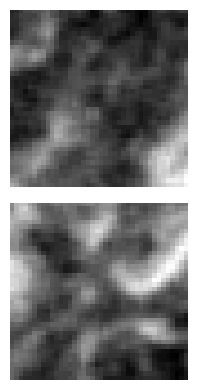

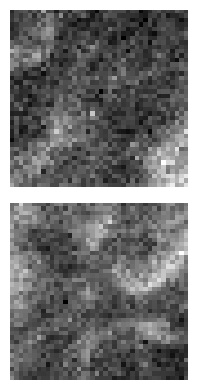

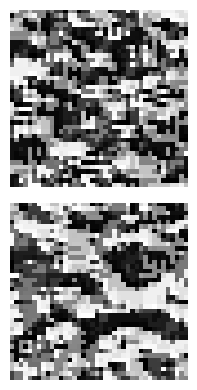

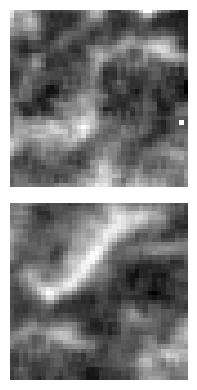

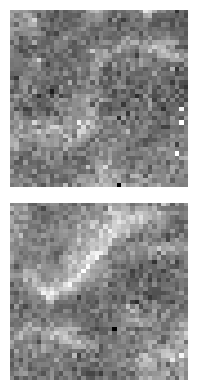

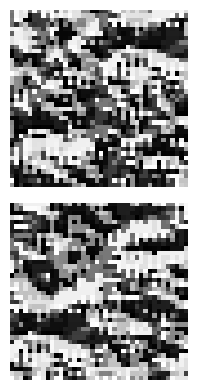

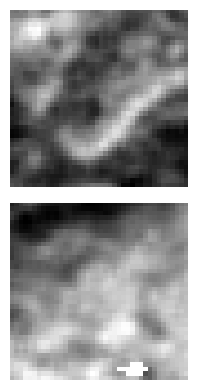

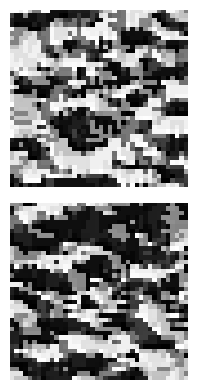

In [84]:
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

def create_matrix(data, unique_lats, unique_lons):
    lat_to_row = {lat: idx for idx, lat in enumerate(unique_lats)}
    lon_to_col = {lon: idx for idx, lon in enumerate(unique_lons)}
    matrix = np.full((len(unique_lats), len(unique_lons)), np.nan)
    for _, row in data.iterrows():
        matrix[lat_to_row[row['latitude']], lon_to_col[row['longitude']]] = row['value']
    return matrix

def get_random_top_left_corners(matrix_shape, submatrix_size, num_submatrices):
    max_row, max_col = matrix_shape[0] - submatrix_size[0], matrix_shape[1] - submatrix_size[1]
    return [(np.random.randint(0, max_row + 1), np.random.randint(0, max_col + 1)) for _ in range(num_submatrices)]

def plot_submatrices(submatrices, num_to_plot=5):
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(8, num_to_plot * 2))
    for i in range(num_to_plot):
        axes[i].imshow(submatrices[i], cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Normalize and create matrices
data_sources = ['sif_743', 'NDVI', 'EVI', 'NIR', 'diff_sif']
unique_lats = sorted(seven_data['latitude'].unique())
unique_lons = sorted(seven_data['longitude'].unique())

matrices = {}
for data_source in data_sources:
    matrices[data_source] = create_matrix(pd.DataFrame({
        'latitude': seven_data['latitude'],
        'longitude': seven_data['longitude'],
        'value': normalize_series(input_scaled_df[data_source])
    }), unique_lats, unique_lons)

# Compute LBP matrix for 'sif_743'
sif_743_matrix = matrices['sif_743']
lbp_matrix = lbp(sif_743_matrix)

# Add LBP matrix to the list of matrices
matrices['lbp_sif_743'] = lbp_matrix

# Create target matrix
target_sif_matrix = create_matrix(pd.DataFrame({
    'latitude': seven_data['latitude'],
    'longitude': seven_data['longitude'],
    'value': input_scaled_df['target_sif']
}), unique_lats, unique_lons)

# Extract submatrices
submatrix_size = (40, 40)
num_submatrices = 200
top_left_corners = get_random_top_left_corners(matrices['sif_743'].shape, submatrix_size, num_submatrices)

submatrices = {source: [] for source in data_sources + ['target_sif', 'lbp_sif_743']}
for row, col in top_left_corners:
    for source in data_sources:
        submatrices[source].append(matrices[source][row:row + submatrix_size[0], col:col + submatrix_size[1]])
    submatrices['target_sif'].append(target_sif_matrix[row:row + submatrix_size[0], col:col + submatrix_size[1]])
    submatrices['lbp_sif_743'].append(lbp_matrix[row:row + submatrix_size[0], col:col + submatrix_size[1]])

# Convert lists to numpy arrays
for key in submatrices:
    submatrices[key] = np.array(submatrices[key])

# Plot some of the extracted submatrices
plot_submatrices(submatrices['sif_743'], num_to_plot=2)
plot_submatrices(submatrices['target_sif'], num_to_plot=2)
plot_submatrices(submatrices['lbp_sif_743'], num_to_plot=2)


#################################################################

# Normalize and create matrices for secSet_14
data_sources_14 = ['sif_743', 'NDVI', 'EVI', 'NIR', 'diff_sif']
unique_lats_14 = sorted(secSet_14['latitude'].unique())
unique_lons_14 = sorted(secSet_14['longitude'].unique())

matrices_14 = {}
for data_source in data_sources_14:
    matrices_14[data_source] = create_matrix(pd.DataFrame({
        'latitude': secSet_14['latitude'],
        'longitude': secSet_14['longitude'],
        'value': normalize_series(input_scaled_2_df[data_source])
    }), unique_lats_14, unique_lons_14)

# Compute LBP matrix for 'sif_743' from secSet_14
sif_743_matrix_14 = matrices_14['sif_743']
lbp_matrix_14 = lbp(sif_743_matrix_14)

# Add LBP matrix to the list of matrices for secSet_14
matrices_14['lbp_sif_743'] = lbp_matrix_14

# Create target matrix for secSet_14
target_sif_matrix_14 = create_matrix(pd.DataFrame({
    'latitude': secSet_14['latitude'],
    'longitude': secSet_14['longitude'],
    'value': input_scaled_2_df['target_sif']
}), unique_lats_14, unique_lons_14)

# Extract submatrices for secSet_14
submatrix_size_14 = (40, 40)
num_submatrices_14 = 200
top_left_corners_14 = get_random_top_left_corners(matrices_14['sif_743'].shape, submatrix_size_14, num_submatrices_14)

submatrices_14 = {source: [] for source in data_sources_14 + ['target_sif', 'lbp_sif_743']}
for row, col in top_left_corners_14:
    for source in data_sources_14:
        submatrices_14[source].append(matrices_14[source][row:row + submatrix_size_14[0], col:col + submatrix_size_14[1]])
    submatrices_14['target_sif'].append(target_sif_matrix_14[row:row + submatrix_size_14[0], col:col + submatrix_size_14[1]])
    submatrices_14['lbp_sif_743'].append(lbp_matrix_14[row:row + submatrix_size_14[0], col:col + submatrix_size_14[1]])

# Convert lists to numpy arrays for secSet_14
for key in submatrices_14:
    submatrices_14[key] = np.array(submatrices_14[key])

# Plot some of the extracted submatrices for secSet_14
plot_submatrices(submatrices_14['sif_743'], num_to_plot=2)
plot_submatrices(submatrices_14['target_sif'], num_to_plot=2)
plot_submatrices(submatrices_14['lbp_sif_743'], num_to_plot=2)



#################################################################

# Repeat similar process for test data
unique_lats_test = sorted(three_data['latitude'].unique())
unique_lons_test = sorted(three_data['longitude'].unique())

test_matrices = {}
for data_source in data_sources:
    test_matrices[data_source] = create_matrix(pd.DataFrame({
        'latitude': three_data['latitude'],
        'longitude': three_data['longitude'],
        'value': normalize_series(merged_df[data_source])
    }), unique_lats_test, unique_lons_test)

# Compute LBP matrix for test data
test_sif_743_matrix = test_matrices['sif_743']
test_lbp_matrix = lbp(test_sif_743_matrix)

# Add LBP matrix to the test matrices
test_matrices['lbp_sif_743'] = test_lbp_matrix

top_left_test_corners = get_random_top_left_corners(test_matrices['sif_743'].shape, submatrix_size, 10)

test_submatrices = {source: [] for source in data_sources + ['lbp_sif_743']}
for row, col in top_left_test_corners:
    for source in data_sources:
        test_submatrices[source].append(test_matrices[source][row:row + submatrix_size[0], col:col + submatrix_size[1]])
    test_submatrices['lbp_sif_743'].append(test_lbp_matrix[row:row + submatrix_size[0], col:col + submatrix_size[1]])

# Convert lists to numpy arrays
for key in test_submatrices:
    test_submatrices[key] = np.array(test_submatrices[key])

plot_submatrices(test_submatrices['sif_743'], num_to_plot=2)
plot_submatrices(test_submatrices['lbp_sif_743'], num_to_plot=2)


### Refill NaN again for newly generated submatrices

In [85]:
def replace_nan_with_zero(submatrices_dict):
    for key in submatrices_dict:
        submatrices_dict[key] = np.nan_to_num(submatrices_dict[key], nan=0)

replace_nan_with_zero(submatrices)

replace_nan_with_zero(submatrices_14)

replace_nan_with_zero(test_submatrices)

for key, matrices in submatrices.items():
    assert not np.isnan(matrices).any(), f"NaN values found in {key}"

for key, matrices in test_submatrices.items():
    assert not np.isnan(matrices).any(), f"NaN values found in {key}"

# plot_submatrices(submatrices['sif_743'], num_to_plot=2)
# plot_submatrices(submatrices['target_sif'], num_to_plot=2)
# plot_submatrices(test_submatrices['sif_743'], num_to_plot=2)

In [86]:
test_three_data = []
test_three_data = {
    'longitude': three_data['longitude'].copy(),
    'latitude': three_data['latitude'].copy(),
    'sif_743': three_data['sif_mean_743'].copy(),
    'NDVI': three_data['NDVI_mean'].copy(),
    'EVI': three_data['EVI_mean'].copy(),
    'NIR': three_data['NIR_REFL_mean'].copy(),
}

test_three_df = pd.DataFrame(test_three_data)
test_three_df.head(5)

,longitude,latitude,sif_743,NDVI,EVI,NIR
0,-100.502966,49.762859,0.883585,3345.600000,1904.458333,2201.040000
1,-100.457106,49.762859,0.312943,2888.346154,1561.538462,1983.769231
2,-100.365385,49.762859,0.336108,3011.500000,1640.576923,1999.461538
3,-100.319525,49.762859,0.278045,3622.807692,2041.807692,2189.500000
4,-100.273665,49.762859,0.370085,3345.304348,1786.304348,2002.739130


In [87]:
print(submatrices['NDVI'].shape)
print(submatrices['EVI'].shape)
print(submatrices_14['NDVI'].shape)
print(submatrices_14['EVI'].shape)

(200, 40, 40)
(200, 40, 40)
(200, 40, 40)
(200, 40, 40)


In [88]:
# targe_sif_submatrices

In [147]:
submatrices_combined = [submatrices, submatrices_14]

combined_submatrices = {}
for key in submatrices.keys():
    combined_submatrices[key] = np.concatenate((submatrices[key], submatrices_14[key]), axis=0)

for key, matrix in combined_submatrices.items():
    print(f"{key}: {matrix.shape}")

sif_743: (400, 40, 40)
NDVI: (400, 40, 40)
EVI: (400, 40, 40)
NIR: (400, 40, 40)
diff_sif: (400, 40, 40)
target_sif: (400, 40, 40)
lbp_sif_743: (400, 40, 40)


## U-NET Model Training and Testing

### Format Input-Target Dataset (converting to tensors)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

class SpatialDataset(Dataset):
    def __init__(self, sif, ndvi, evi, nir, lbp, diff, target_sif):
        self.sif = torch.tensor(sif, dtype=torch.float32).unsqueeze(1)
        self.ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(1)
        self.evi = torch.tensor(evi, dtype=torch.float32).unsqueeze(1)
        self.nir = torch.tensor(nir, dtype=torch.float32).unsqueeze(1)
        self.lbp = torch.tensor(lbp, dtype=torch.float32).unsqueeze(1) * 0.5  # Adjust influence of LBP
        self.diff = torch.tensor(diff, dtype=torch.float32).unsqueeze(1)
        self.target_sif = torch.tensor(target_sif, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.sif)

    def __getitem__(self, idx):
        inputs = torch.cat((self.sif[idx], self.ndvi[idx], self.evi[idx], self.nir[idx], self.lbp[idx], self.diff[idx]), dim=0)
        target = self.target_sif[idx]
        return inputs, target

sif = combined_submatrices['sif_743']
ndvi = combined_submatrices['NDVI']
evi = combined_submatrices['EVI']
nir = combined_submatrices['NIR']
diff = combined_submatrices['diff_sif']
lbp = combined_submatrices['lbp_sif_743']
target_sif = combined_submatrices['target_sif']

full_dataset = SpatialDataset(sif, ndvi, evi, nir, lbp, diff, target_sif)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Model Training-Testing

In [143]:


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(6, 16)                  # 6 input channels for 6 features
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        self.bottleneck = self.conv_block(128, 256)

        self.up4 = self.upconv_block(256, 128)
        self.dec4 = self.conv_block(256, 128)

        self.up3 = self.upconv_block(128, 64)
        self.dec3 = self.conv_block(128, 64)

        self.up2 = self.upconv_block(64, 32)
        self.dec2 = self.conv_block(64, 32)

        self.up1 = self.upconv_block(32, 16)
        self.dec1 = self.conv_block(32, 16)


        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        return block

    def upconv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):

        enc1 = self.enc1(x)
        pool1 = F.max_pool2d(enc1, kernel_size=2, stride=2)

        enc2 = self.enc2(pool1)
        pool2 = F.max_pool2d(enc2, kernel_size=2, stride=2)

        enc3 = self.enc3(pool2)
        pool3 = F.max_pool2d(enc3, kernel_size=2, stride=2)

        enc4 = self.enc4(pool3)
        pool4 = F.max_pool2d(enc4, kernel_size=2, stride=2)


        bottleneck = self.bottleneck(pool4)

        up4 = self.up4(bottleneck)
        up4 = F.interpolate(up4, size=enc4.size()[2:], mode='bilinear', align_corners=False)
        up4 = torch.cat((up4, enc4), dim=1)
        dec4 = self.dec4(up4)

        up3 = self.up3(dec4)
        up3 = F.interpolate(up3, size=enc3.size()[2:], mode='bilinear', align_corners=False)
        up3 = torch.cat((up3, enc3), dim=1)
        dec3 = self.dec3(up3)

        up2 = self.up2(dec3)
        up2 = F.interpolate(up2, size=enc2.size()[2:], mode='bilinear', align_corners=False)
        up2 = torch.cat((up2, enc2), dim=1)
        dec2 = self.dec2(up2)

        up1 = self.up1(dec2)
        up1 = F.interpolate(up1, size=enc1.size()[2:], mode='bilinear', align_corners=False)
        up1 = torch.cat((up1, enc1), dim=1)
        dec1 = self.dec1(up1)

        output = self.final_conv(dec1)
        return output
    
    
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

num_epochs = 500
train_losses = []
test_losses = []
r2_scores = []
mae_scores = []
rmse_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_predictions = []
        test_targets = []
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)

            test_predictions.append(outputs)
            test_targets.append(targets)

        test_epoch_loss = test_running_loss / len(test_dataset)
        test_losses.append(test_epoch_loss)

        test_predictions = torch.cat(test_predictions, dim=0).cpu().numpy().reshape(-1, 40*40)
        test_targets = torch.cat(test_targets, dim=0).cpu().numpy().reshape(-1, 40*40)

        r2 = r2_score(test_targets, test_predictions)
        mae = mean_absolute_error(test_targets, test_predictions)
        rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))

        r2_scores.append(r2)
        mae_scores.append(mae)
        rmse_scores.append(rmse)

    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Test Loss: {test_epoch_loss:.4f} R2 Score: {r2:.4f} MAE: {mae:.4f} RMSE: {rmse:.4f}')

Epoch [1/500] Train Loss: 0.4761 Test Loss: 0.3281 R2 Score: -0.0984 MAE: 0.4629 RMSE: 0.5728
Epoch [2/500] Train Loss: 0.3061 Test Loss: 0.2954 R2 Score: 0.0065 MAE: 0.4372 RMSE: 0.5435
Epoch [3/500] Train Loss: 0.2864 Test Loss: 0.2819 R2 Score: 0.0536 MAE: 0.4325 RMSE: 0.5309
Epoch [4/500] Train Loss: 0.2657 Test Loss: 0.2594 R2 Score: 0.1287 MAE: 0.4118 RMSE: 0.5093
Epoch [5/500] Train Loss: 0.2453 Test Loss: 0.2451 R2 Score: 0.1780 MAE: 0.3925 RMSE: 0.4950
Epoch [6/500] Train Loss: 0.2816 Test Loss: 0.2475 R2 Score: 0.1709 MAE: 0.4010 RMSE: 0.4975
Epoch [7/500] Train Loss: 0.2721 Test Loss: 0.2706 R2 Score: 0.0865 MAE: 0.4293 RMSE: 0.5202
Epoch [8/500] Train Loss: 0.2433 Test Loss: 0.2744 R2 Score: 0.0711 MAE: 0.4352 RMSE: 0.5239
Epoch [9/500] Train Loss: 0.2241 Test Loss: 0.2238 R2 Score: 0.2440 MAE: 0.3895 RMSE: 0.4730
Epoch [10/500] Train Loss: 0.2043 Test Loss: 0.2124 R2 Score: 0.2872 MAE: 0.3576 RMSE: 0.4608
Epoch [11/500] Train Loss: 0.1858 Test Loss: 0.1829 R2 Score: 0.3813

Epoch [89/500] Train Loss: 0.0413 Test Loss: 0.0438 R2 Score: 0.8520 MAE: 0.1590 RMSE: 0.2093
Epoch [90/500] Train Loss: 0.0410 Test Loss: 0.0446 R2 Score: 0.8490 MAE: 0.1606 RMSE: 0.2112
Epoch [91/500] Train Loss: 0.0409 Test Loss: 0.0436 R2 Score: 0.8525 MAE: 0.1586 RMSE: 0.2089
Epoch [92/500] Train Loss: 0.0405 Test Loss: 0.0438 R2 Score: 0.8518 MAE: 0.1589 RMSE: 0.2093
Epoch [93/500] Train Loss: 0.0403 Test Loss: 0.0438 R2 Score: 0.8516 MAE: 0.1589 RMSE: 0.2094
Epoch [94/500] Train Loss: 0.0401 Test Loss: 0.0433 R2 Score: 0.8535 MAE: 0.1579 RMSE: 0.2082
Epoch [95/500] Train Loss: 0.0401 Test Loss: 0.0435 R2 Score: 0.8526 MAE: 0.1584 RMSE: 0.2087
Epoch [96/500] Train Loss: 0.0396 Test Loss: 0.0435 R2 Score: 0.8528 MAE: 0.1583 RMSE: 0.2085
Epoch [97/500] Train Loss: 0.0396 Test Loss: 0.0435 R2 Score: 0.8526 MAE: 0.1585 RMSE: 0.2086
Epoch [98/500] Train Loss: 0.0397 Test Loss: 0.0444 R2 Score: 0.8495 MAE: 0.1601 RMSE: 0.2107
Epoch [99/500] Train Loss: 0.0392 Test Loss: 0.0429 R2 Score

Epoch [176/500] Train Loss: 0.0324 Test Loss: 0.0385 R2 Score: 0.8692 MAE: 0.1495 RMSE: 0.1962
Epoch [177/500] Train Loss: 0.0323 Test Loss: 0.0383 R2 Score: 0.8700 MAE: 0.1490 RMSE: 0.1957
Epoch [178/500] Train Loss: 0.0324 Test Loss: 0.0387 R2 Score: 0.8685 MAE: 0.1499 RMSE: 0.1968
Epoch [179/500] Train Loss: 0.0324 Test Loss: 0.0383 R2 Score: 0.8701 MAE: 0.1489 RMSE: 0.1957
Epoch [180/500] Train Loss: 0.0323 Test Loss: 0.0388 R2 Score: 0.8681 MAE: 0.1503 RMSE: 0.1970
Epoch [181/500] Train Loss: 0.0322 Test Loss: 0.0382 R2 Score: 0.8703 MAE: 0.1488 RMSE: 0.1955
Epoch [182/500] Train Loss: 0.0319 Test Loss: 0.0381 R2 Score: 0.8705 MAE: 0.1488 RMSE: 0.1953
Epoch [183/500] Train Loss: 0.0317 Test Loss: 0.0380 R2 Score: 0.8710 MAE: 0.1484 RMSE: 0.1949
Epoch [184/500] Train Loss: 0.0318 Test Loss: 0.0383 R2 Score: 0.8698 MAE: 0.1491 RMSE: 0.1957
Epoch [185/500] Train Loss: 0.0319 Test Loss: 0.0380 R2 Score: 0.8711 MAE: 0.1485 RMSE: 0.1949
Epoch [186/500] Train Loss: 0.0317 Test Loss: 0.03

Epoch [263/500] Train Loss: 0.0302 Test Loss: 0.0370 R2 Score: 0.8740 MAE: 0.1461 RMSE: 0.1923
Epoch [264/500] Train Loss: 0.0287 Test Loss: 0.0360 R2 Score: 0.8774 MAE: 0.1439 RMSE: 0.1898
Epoch [265/500] Train Loss: 0.0273 Test Loss: 0.0368 R2 Score: 0.8747 MAE: 0.1454 RMSE: 0.1918
Epoch [266/500] Train Loss: 0.0266 Test Loss: 0.0356 R2 Score: 0.8788 MAE: 0.1433 RMSE: 0.1887
Epoch [267/500] Train Loss: 0.0261 Test Loss: 0.0356 R2 Score: 0.8789 MAE: 0.1430 RMSE: 0.1886
Epoch [268/500] Train Loss: 0.0261 Test Loss: 0.0355 R2 Score: 0.8790 MAE: 0.1431 RMSE: 0.1885
Epoch [269/500] Train Loss: 0.0272 Test Loss: 0.0362 R2 Score: 0.8768 MAE: 0.1442 RMSE: 0.1902
Epoch [270/500] Train Loss: 0.0275 Test Loss: 0.0361 R2 Score: 0.8773 MAE: 0.1445 RMSE: 0.1899
Epoch [271/500] Train Loss: 0.0263 Test Loss: 0.0353 R2 Score: 0.8799 MAE: 0.1427 RMSE: 0.1879
Epoch [272/500] Train Loss: 0.0257 Test Loss: 0.0360 R2 Score: 0.8773 MAE: 0.1439 RMSE: 0.1898
Epoch [273/500] Train Loss: 0.0257 Test Loss: 0.03

Epoch [350/500] Train Loss: 0.0152 Test Loss: 0.0254 R2 Score: 0.9132 MAE: 0.1206 RMSE: 0.1594
Epoch [351/500] Train Loss: 0.0150 Test Loss: 0.0255 R2 Score: 0.9129 MAE: 0.1206 RMSE: 0.1597
Epoch [352/500] Train Loss: 0.0152 Test Loss: 0.0254 R2 Score: 0.9132 MAE: 0.1200 RMSE: 0.1593
Epoch [353/500] Train Loss: 0.0158 Test Loss: 0.0251 R2 Score: 0.9144 MAE: 0.1200 RMSE: 0.1584
Epoch [354/500] Train Loss: 0.0149 Test Loss: 0.0251 R2 Score: 0.9142 MAE: 0.1194 RMSE: 0.1584
Epoch [355/500] Train Loss: 0.0163 Test Loss: 0.0313 R2 Score: 0.8929 MAE: 0.1347 RMSE: 0.1770
Epoch [356/500] Train Loss: 0.0161 Test Loss: 0.0253 R2 Score: 0.9136 MAE: 0.1202 RMSE: 0.1590
Epoch [357/500] Train Loss: 0.0148 Test Loss: 0.0243 R2 Score: 0.9169 MAE: 0.1181 RMSE: 0.1559
Epoch [358/500] Train Loss: 0.0141 Test Loss: 0.0248 R2 Score: 0.9150 MAE: 0.1190 RMSE: 0.1575
Epoch [359/500] Train Loss: 0.0140 Test Loss: 0.0233 R2 Score: 0.9202 MAE: 0.1148 RMSE: 0.1527
Epoch [360/500] Train Loss: 0.0135 Test Loss: 0.02

Epoch [437/500] Train Loss: 0.0151 Test Loss: 0.0145 R2 Score: 0.9509 MAE: 0.0912 RMSE: 0.1203
Epoch [438/500] Train Loss: 0.0142 Test Loss: 0.0186 R2 Score: 0.9370 MAE: 0.1043 RMSE: 0.1363
Epoch [439/500] Train Loss: 0.0168 Test Loss: 0.0221 R2 Score: 0.9251 MAE: 0.1191 RMSE: 0.1487
Epoch [440/500] Train Loss: 0.0155 Test Loss: 0.0144 R2 Score: 0.9513 MAE: 0.0906 RMSE: 0.1198
Epoch [441/500] Train Loss: 0.0136 Test Loss: 0.0198 R2 Score: 0.9326 MAE: 0.1095 RMSE: 0.1408
Epoch [442/500] Train Loss: 0.0136 Test Loss: 0.0145 R2 Score: 0.9508 MAE: 0.0909 RMSE: 0.1204
Epoch [443/500] Train Loss: 0.0142 Test Loss: 0.0154 R2 Score: 0.9477 MAE: 0.0954 RMSE: 0.1240
Epoch [444/500] Train Loss: 0.0134 Test Loss: 0.0157 R2 Score: 0.9468 MAE: 0.0948 RMSE: 0.1253
Epoch [445/500] Train Loss: 0.0122 Test Loss: 0.0140 R2 Score: 0.9527 MAE: 0.0890 RMSE: 0.1182
Epoch [446/500] Train Loss: 0.0114 Test Loss: 0.0126 R2 Score: 0.9573 MAE: 0.0839 RMSE: 0.1123
Epoch [447/500] Train Loss: 0.0116 Test Loss: 0.01

### Visualize Model Performance and Results

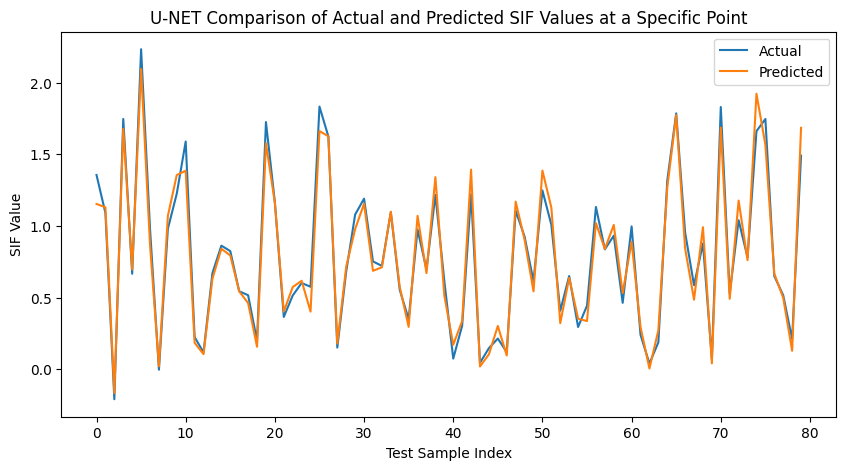

In [145]:
# Ensure the test targets and predictions are converted correctly
test_targets_np = test_targets.cpu().numpy() if isinstance(test_targets, torch.Tensor) else test_targets
test_predictions_np = test_predictions.cpu().numpy() if isinstance(test_predictions, torch.Tensor) else test_predictions

# Reshape the targets and predictions to their original shape
test_targets_np = test_targets_np.reshape(-1, 1, 40, 40)
test_predictions_np = test_predictions_np.reshape(-1, 1, 40, 40)

# Select a specific point (e.g., the center of the 40x40 grid)
point_x, point_y = 20, 20  # Center point

# Extract the values at the selected point for all test samples
targets_point = test_targets_np[:, 0, point_x, point_y]
predictions_point = test_predictions_np[:, 0, point_x, point_y]

# Plot the line plot
plt.figure(figsize=(10, 5))
plt.plot(targets_point, label='Actual')
plt.plot(predictions_point, label='Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('SIF Value')
plt.title('U-NET Comparison of Actual and Predicted SIF Values at a Specific Point')
plt.legend()
plt.show()


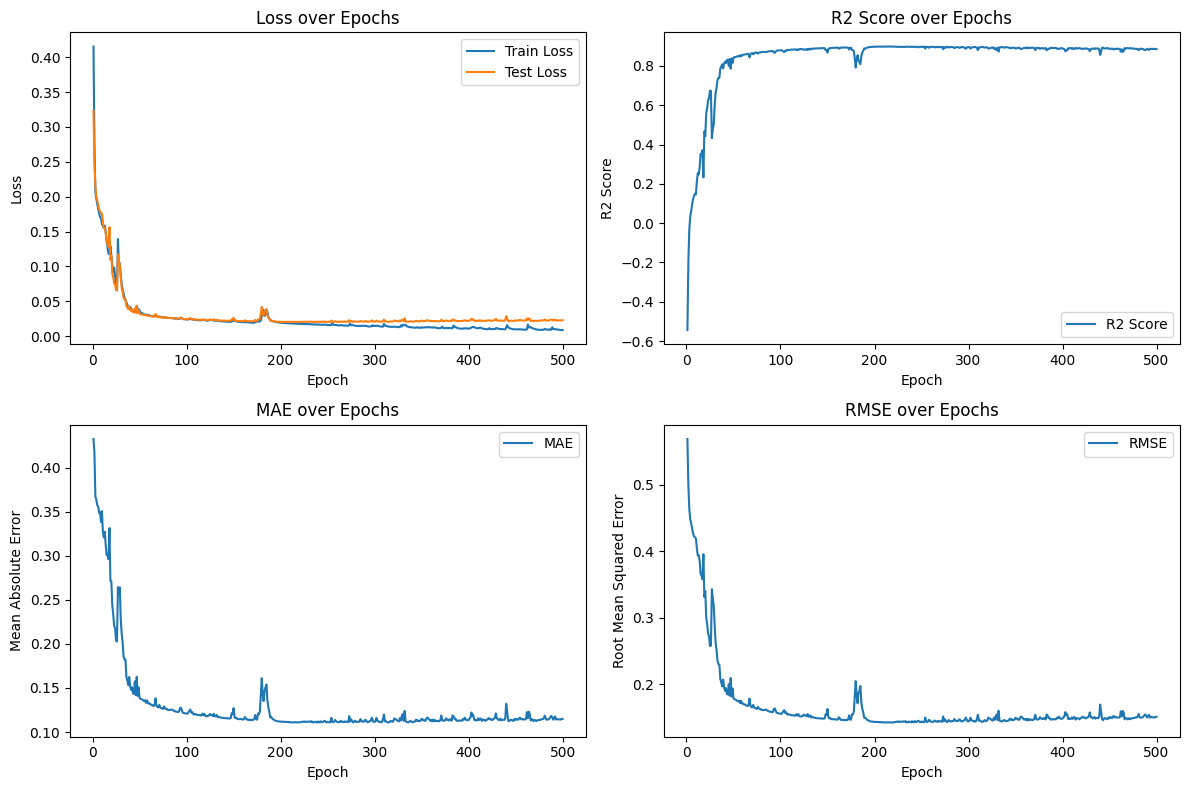

In [92]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(2, 2, 2)
plt.plot(epochs, r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.title('R2 Score over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, mae_scores, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE over Epochs')

plt.subplot(2, 2, 4)
plt.plot(epochs, rmse_scores, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.title('RMSE over Epochs')

plt.tight_layout()
plt.show()


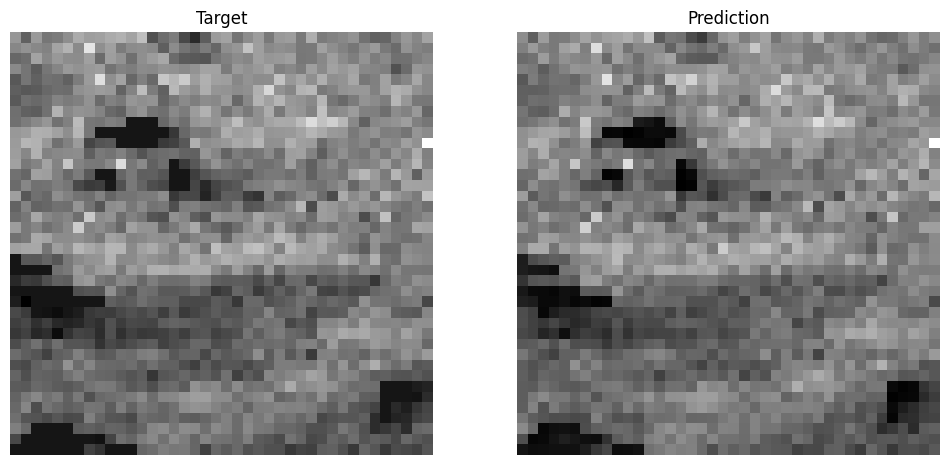

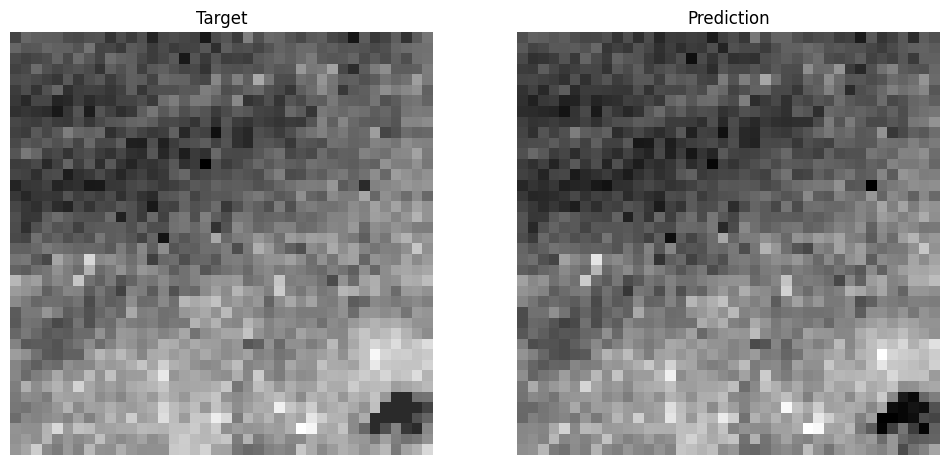

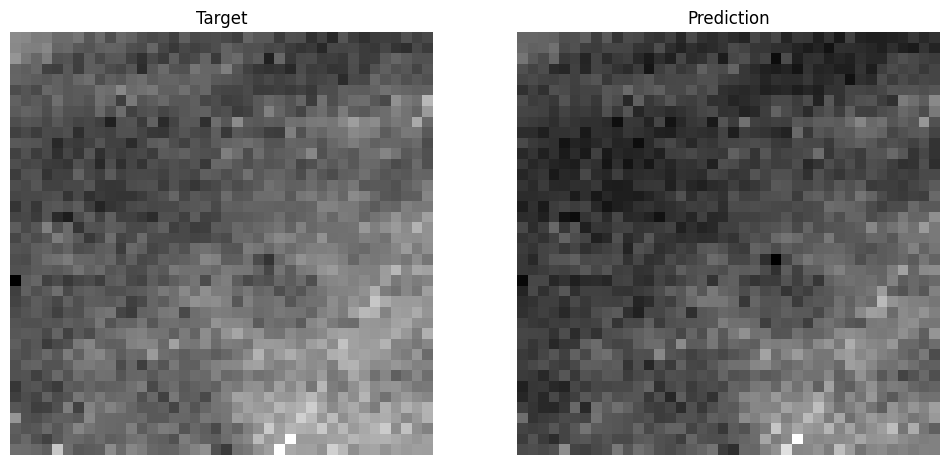

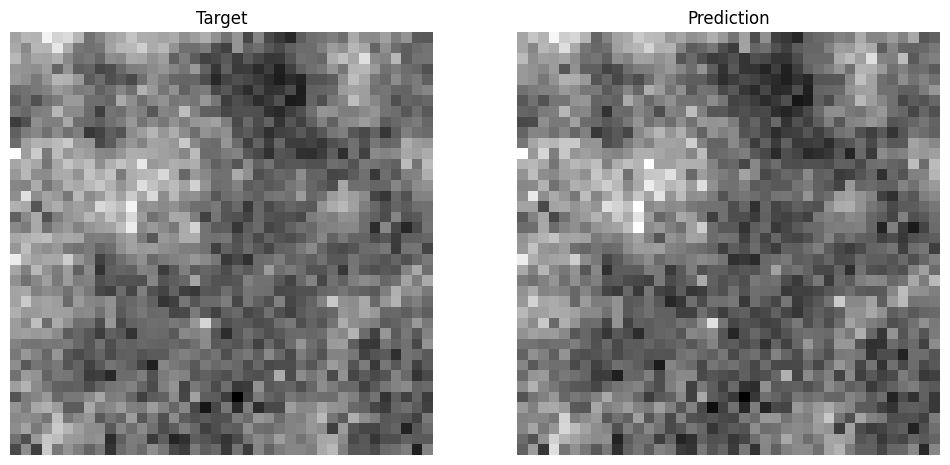

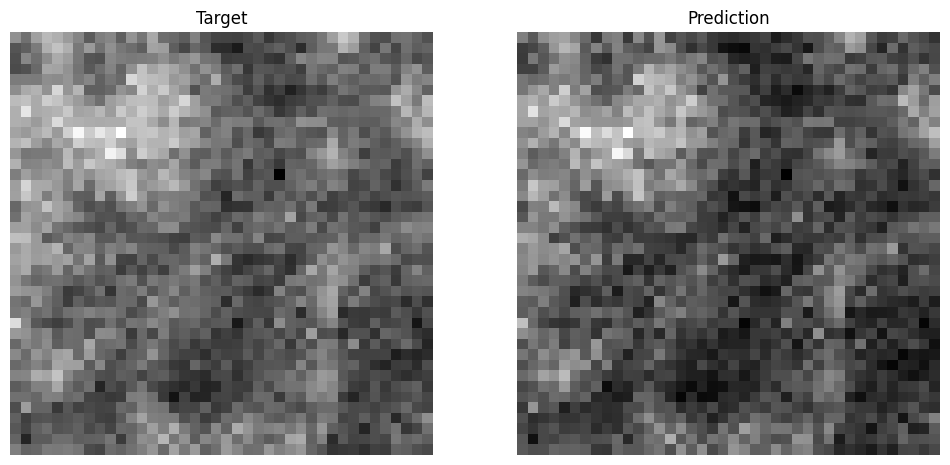

In [146]:
test_targets_np = test_targets.reshape(-1, 1, 40, 40)
test_predictions_np = test_predictions.reshape(-1, 1, 40, 40)

import matplotlib.pyplot as plt

def visualize_target_vs_prediction(targets, predictions, index):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(targets[index, 0, :, :], cmap='gray')
    axes[0].set_title('Target')
    axes[0].axis('off')

    axes[1].imshow(predictions[index, 0, :, :], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.show()

visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=5)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=20)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=4)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=16)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=11)

In [142]:
submatrices_combined

[{'sif_743': array([[[0.10010916, 0.11564291, 0.15609845, ..., 0.13598525,
           0.16204355, 0.15837246],
          [0.12008216, 0.13528187, 0.17452016, ..., 0.09292649,
           0.09736333, 0.0952005 ],
          [0.12477183, 0.12562603, 0.16123818, ..., 0.06760589,
           0.06321546, 0.08095458],
          ...,
          [0.3244313 , 0.34551618, 0.32876662, ..., 0.58740196,
           0.58323439, 0.65190574],
          [0.38541046, 0.36841001, 0.31220995, ..., 0.62368413,
           0.60907226, 0.66491556],
          [0.44390387, 0.40792723, 0.34213755, ..., 0.58618906,
           0.57935204, 0.63152811]],
  
         [[0.37181523, 0.48495982, 0.51371851, ..., 0.31042226,
           0.3140542 , 0.32623108],
          [0.36443146, 0.48231454, 0.54242354, ..., 0.34448794,
           0.36992843, 0.38167604],
          [0.42231673, 0.49036978, 0.5276739 , ..., 0.38708213,
           0.44329863, 0.44836923],
          ...,
          [0.28573155, 0.25356619, 0.23193361, ..., 0.0

### Repeat same with CNN-Model for Comparison

(400, 40, 40)
Epoch 1/500, Loss: 0.4018, Test Loss: 0.2631, R2: 0.1179, MAE: 0.4105, RMSE: 0.5129
Epoch 2/500, Loss: 0.2607, Test Loss: 0.2421, R2: 0.1862, MAE: 0.3829, RMSE: 0.4920
Epoch 3/500, Loss: 0.2413, Test Loss: 0.2421, R2: 0.1802, MAE: 0.3805, RMSE: 0.4920
Epoch 4/500, Loss: 0.2147, Test Loss: 0.2057, R2: 0.3053, MAE: 0.3557, RMSE: 0.4535
Epoch 5/500, Loss: 0.1918, Test Loss: 0.2034, R2: 0.3224, MAE: 0.3422, RMSE: 0.4510
Epoch 6/500, Loss: 0.1782, Test Loss: 0.1783, R2: 0.4039, MAE: 0.3208, RMSE: 0.4223
Epoch 7/500, Loss: 0.1709, Test Loss: 0.1866, R2: 0.3781, MAE: 0.3262, RMSE: 0.4320
Epoch 8/500, Loss: 0.1646, Test Loss: 0.1709, R2: 0.4309, MAE: 0.3129, RMSE: 0.4133
Epoch 9/500, Loss: 0.1614, Test Loss: 0.1635, R2: 0.4551, MAE: 0.3069, RMSE: 0.4044
Epoch 10/500, Loss: 0.1610, Test Loss: 0.1595, R2: 0.4683, MAE: 0.3006, RMSE: 0.3994
Epoch 11/500, Loss: 0.1519, Test Loss: 0.1531, R2: 0.4896, MAE: 0.2951, RMSE: 0.3913
Epoch 12/500, Loss: 0.1481, Test Loss: 0.1491, R2: 0.5011, M

Epoch 98/500, Loss: 0.0425, Test Loss: 0.1224, R2: 0.5867, MAE: 0.2648, RMSE: 0.3499
Epoch 99/500, Loss: 0.0423, Test Loss: 0.1223, R2: 0.5875, MAE: 0.2641, RMSE: 0.3497
Epoch 100/500, Loss: 0.0421, Test Loss: 0.1233, R2: 0.5844, MAE: 0.2649, RMSE: 0.3511
Epoch 101/500, Loss: 0.0416, Test Loss: 0.1230, R2: 0.5846, MAE: 0.2658, RMSE: 0.3507
Epoch 102/500, Loss: 0.0413, Test Loss: 0.1247, R2: 0.5801, MAE: 0.2663, RMSE: 0.3531
Epoch 103/500, Loss: 0.0411, Test Loss: 0.1243, R2: 0.5803, MAE: 0.2667, RMSE: 0.3525
Epoch 104/500, Loss: 0.0413, Test Loss: 0.1260, R2: 0.5739, MAE: 0.2693, RMSE: 0.3550
Epoch 105/500, Loss: 0.0437, Test Loss: 0.1262, R2: 0.5737, MAE: 0.2682, RMSE: 0.3553
Epoch 106/500, Loss: 0.0440, Test Loss: 0.1308, R2: 0.5581, MAE: 0.2761, RMSE: 0.3617
Epoch 107/500, Loss: 0.0478, Test Loss: 0.1351, R2: 0.5444, MAE: 0.2786, RMSE: 0.3675
Epoch 108/500, Loss: 0.0442, Test Loss: 0.1255, R2: 0.5767, MAE: 0.2689, RMSE: 0.3542
Epoch 109/500, Loss: 0.0412, Test Loss: 0.1238, R2: 0.58

Epoch 194/500, Loss: 0.0213, Test Loss: 0.1395, R2: 0.5282, MAE: 0.2841, RMSE: 0.3735
Epoch 195/500, Loss: 0.0208, Test Loss: 0.1401, R2: 0.5272, MAE: 0.2843, RMSE: 0.3742
Epoch 196/500, Loss: 0.0203, Test Loss: 0.1400, R2: 0.5264, MAE: 0.2851, RMSE: 0.3742
Epoch 197/500, Loss: 0.0202, Test Loss: 0.1408, R2: 0.5241, MAE: 0.2855, RMSE: 0.3752
Epoch 198/500, Loss: 0.0203, Test Loss: 0.1423, R2: 0.5196, MAE: 0.2867, RMSE: 0.3772
Epoch 199/500, Loss: 0.0209, Test Loss: 0.1417, R2: 0.5208, MAE: 0.2863, RMSE: 0.3765
Epoch 200/500, Loss: 0.0211, Test Loss: 0.1412, R2: 0.5230, MAE: 0.2857, RMSE: 0.3758
Epoch 201/500, Loss: 0.0221, Test Loss: 0.1431, R2: 0.5159, MAE: 0.2878, RMSE: 0.3782
Epoch 202/500, Loss: 0.0226, Test Loss: 0.1439, R2: 0.5130, MAE: 0.2885, RMSE: 0.3794
Epoch 203/500, Loss: 0.0224, Test Loss: 0.1421, R2: 0.5201, MAE: 0.2866, RMSE: 0.3770
Epoch 204/500, Loss: 0.0220, Test Loss: 0.1411, R2: 0.5229, MAE: 0.2866, RMSE: 0.3757
Epoch 205/500, Loss: 0.0217, Test Loss: 0.1407, R2: 0.

Epoch 290/500, Loss: 0.0165, Test Loss: 0.1415, R2: 0.5221, MAE: 0.2860, RMSE: 0.3762
Epoch 291/500, Loss: 0.0166, Test Loss: 0.1408, R2: 0.5245, MAE: 0.2854, RMSE: 0.3752
Epoch 292/500, Loss: 0.0166, Test Loss: 0.1414, R2: 0.5224, MAE: 0.2860, RMSE: 0.3760
Epoch 293/500, Loss: 0.0166, Test Loss: 0.1410, R2: 0.5239, MAE: 0.2857, RMSE: 0.3755
Epoch 294/500, Loss: 0.0166, Test Loss: 0.1411, R2: 0.5237, MAE: 0.2858, RMSE: 0.3756
Epoch 295/500, Loss: 0.0167, Test Loss: 0.1410, R2: 0.5234, MAE: 0.2859, RMSE: 0.3755
Epoch 296/500, Loss: 0.0168, Test Loss: 0.1406, R2: 0.5251, MAE: 0.2854, RMSE: 0.3750
Epoch 297/500, Loss: 0.0170, Test Loss: 0.1435, R2: 0.5163, MAE: 0.2877, RMSE: 0.3788
Epoch 298/500, Loss: 0.0175, Test Loss: 0.1416, R2: 0.5220, MAE: 0.2862, RMSE: 0.3763
Epoch 299/500, Loss: 0.0177, Test Loss: 0.1416, R2: 0.5219, MAE: 0.2861, RMSE: 0.3763
Epoch 300/500, Loss: 0.0176, Test Loss: 0.1414, R2: 0.5227, MAE: 0.2862, RMSE: 0.3761
Epoch 301/500, Loss: 0.0177, Test Loss: 0.1424, R2: 0.

Epoch 386/500, Loss: 0.0165, Test Loss: 0.1404, R2: 0.5259, MAE: 0.2858, RMSE: 0.3747
Epoch 387/500, Loss: 0.0164, Test Loss: 0.1399, R2: 0.5280, MAE: 0.2846, RMSE: 0.3740
Epoch 388/500, Loss: 0.0163, Test Loss: 0.1401, R2: 0.5276, MAE: 0.2848, RMSE: 0.3743
Epoch 389/500, Loss: 0.0161, Test Loss: 0.1400, R2: 0.5280, MAE: 0.2842, RMSE: 0.3741
Epoch 390/500, Loss: 0.0164, Test Loss: 0.1411, R2: 0.5241, MAE: 0.2857, RMSE: 0.3756
Epoch 391/500, Loss: 0.0167, Test Loss: 0.1407, R2: 0.5256, MAE: 0.2849, RMSE: 0.3752
Epoch 392/500, Loss: 0.0169, Test Loss: 0.1408, R2: 0.5251, MAE: 0.2853, RMSE: 0.3752
Epoch 393/500, Loss: 0.0173, Test Loss: 0.1415, R2: 0.5225, MAE: 0.2866, RMSE: 0.3762
Epoch 394/500, Loss: 0.0172, Test Loss: 0.1406, R2: 0.5245, MAE: 0.2863, RMSE: 0.3750
Epoch 395/500, Loss: 0.0184, Test Loss: 0.1394, R2: 0.5293, MAE: 0.2851, RMSE: 0.3733
Epoch 396/500, Loss: 0.0184, Test Loss: 0.1408, R2: 0.5255, MAE: 0.2845, RMSE: 0.3752
Epoch 397/500, Loss: 0.0182, Test Loss: 0.1392, R2: 0.

Epoch 482/500, Loss: 0.0161, Test Loss: 0.1388, R2: 0.5317, MAE: 0.2835, RMSE: 0.3726
Epoch 483/500, Loss: 0.0160, Test Loss: 0.1387, R2: 0.5323, MAE: 0.2833, RMSE: 0.3724
Epoch 484/500, Loss: 0.0159, Test Loss: 0.1384, R2: 0.5332, MAE: 0.2829, RMSE: 0.3721
Epoch 485/500, Loss: 0.0157, Test Loss: 0.1383, R2: 0.5339, MAE: 0.2826, RMSE: 0.3719
Epoch 486/500, Loss: 0.0158, Test Loss: 0.1376, R2: 0.5363, MAE: 0.2817, RMSE: 0.3710
Epoch 487/500, Loss: 0.0158, Test Loss: 0.1390, R2: 0.5310, MAE: 0.2835, RMSE: 0.3728
Epoch 488/500, Loss: 0.0159, Test Loss: 0.1383, R2: 0.5332, MAE: 0.2833, RMSE: 0.3720
Epoch 489/500, Loss: 0.0158, Test Loss: 0.1376, R2: 0.5359, MAE: 0.2822, RMSE: 0.3710
Epoch 490/500, Loss: 0.0159, Test Loss: 0.1376, R2: 0.5359, MAE: 0.2822, RMSE: 0.3710
Epoch 491/500, Loss: 0.0161, Test Loss: 0.1384, R2: 0.5331, MAE: 0.2828, RMSE: 0.3721
Epoch 492/500, Loss: 0.0175, Test Loss: 0.1398, R2: 0.5287, MAE: 0.2843, RMSE: 0.3738
Epoch 493/500, Loss: 0.0180, Test Loss: 0.1389, R2: 0.

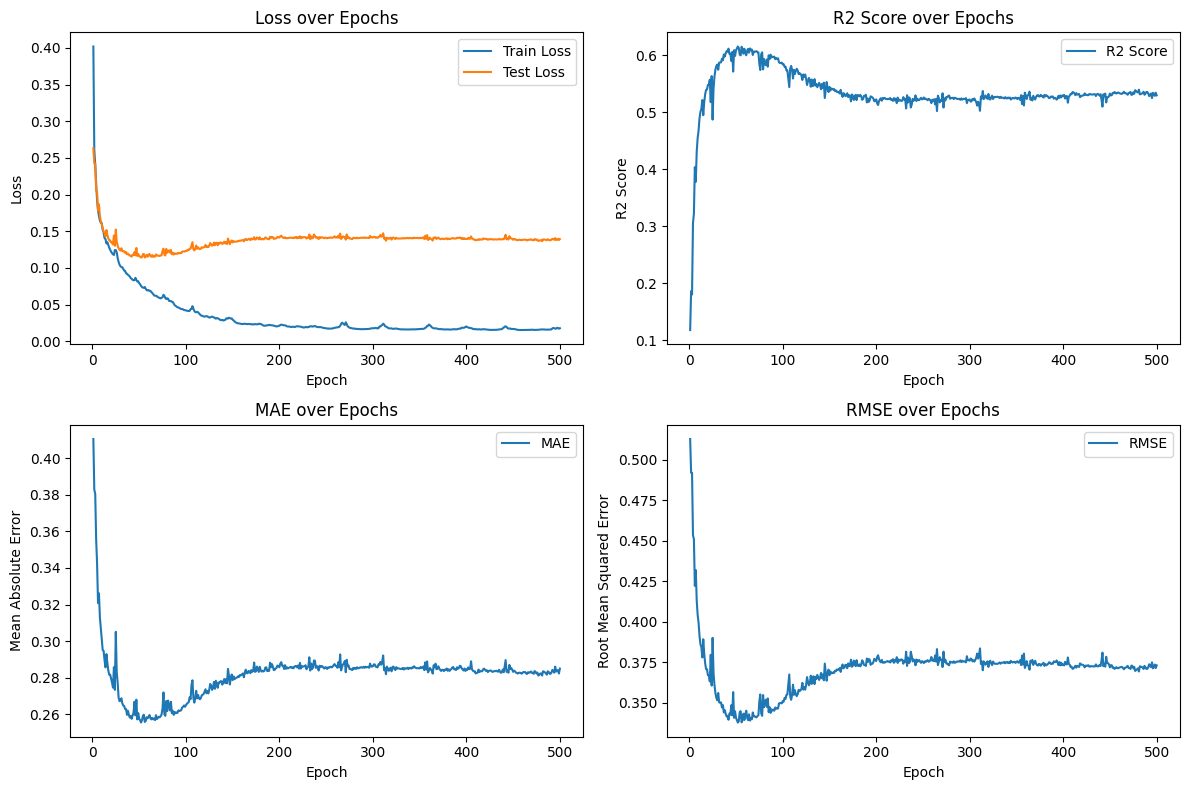

In [152]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


sif = combined_submatrices['sif_743']
print(sif.shape)
ndvi = combined_submatrices['NDVI']
evi = combined_submatrices['EVI']
nir = combined_submatrices['NIR']
target_sif = combined_submatrices['target_sif']

new = np.stack([sif, ndvi, evi, nir, target_sif], axis=1)

# Define a custom Dataset class
class SpatialDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


features = new[:, :4, :, :]  
targets = new[:, 4:, :, :]  


full_dataset = SpatialDataset(features, targets)


train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self._to_linear = 128 * 5 * 5  

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 40 * 40) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 40, 40)  
        return x

model = CNNRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
train_losses = []
test_losses = []
r2_scores = []
mae_scores = []
rmse_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_predictions = []
        test_targets = []
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item() * inputs.size(0)

            test_predictions.append(outputs)
            test_targets.append(targets)

        test_epoch_loss = test_running_loss / len(test_dataset)
        test_losses.append(test_epoch_loss)

        test_predictions = torch.cat(test_predictions, dim=0).cpu().numpy().reshape(-1, 1600)
        test_targets = torch.cat(test_targets, dim=0).cpu().numpy().reshape(-1, 1600)

        r2 = r2_score(test_targets, test_predictions)
        mae = mean_absolute_error(test_targets, test_predictions)
        rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))

        r2_scores.append(r2)
        mae_scores.append(mae)
        rmse_scores.append(rmse)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(2, 2, 2)
plt.plot(epochs, r2_scores, label='R2 Score')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.legend()
plt.title('R2 Score over Epochs')

plt.subplot(2, 2, 3)
plt.plot(epochs, mae_scores, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE over Epochs')

plt.subplot(2, 2, 4)
plt.plot(epochs, rmse_scores, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.title('RMSE over Epochs')

plt.tight_layout()
plt.show()


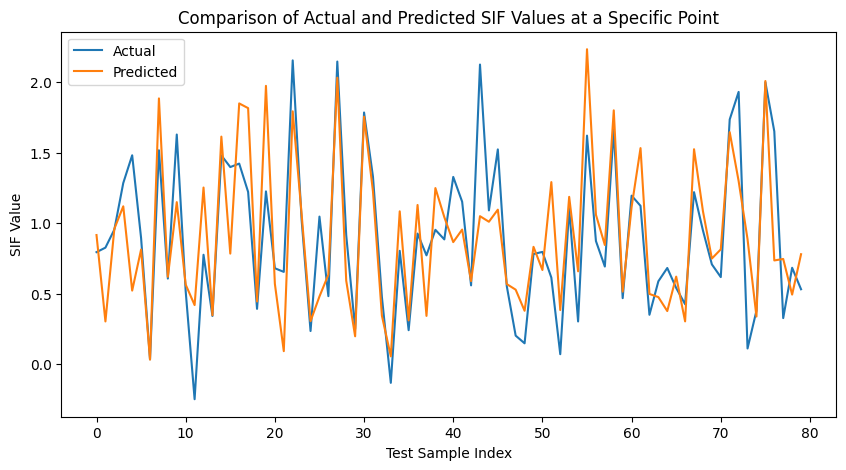

In [153]:
test_targets_np = test_targets.cpu().numpy() if isinstance(test_targets, torch.Tensor) else test_targets
test_predictions_np = test_predictions.cpu().numpy() if isinstance(test_predictions, torch.Tensor) else test_predictions

test_targets_np = test_targets_np.reshape(-1, 1, 40, 40)
test_predictions_np = test_predictions_np.reshape(-1, 1, 40, 40)
point_x, point_y = 20, 20 
targets_point = test_targets_np[:, 0, point_x, point_y]
predictions_point = test_predictions_np[:, 0, point_x, point_y]

plt.figure(figsize=(10, 5))
plt.plot(targets_point, label='Actual')
plt.plot(predictions_point, label='Predicted')
plt.xlabel('Test Sample Index')
plt.ylabel('SIF Value')
plt.title('Comparison of Actual and Predicted SIF Values at a Specific Point')
plt.legend()
plt.show()


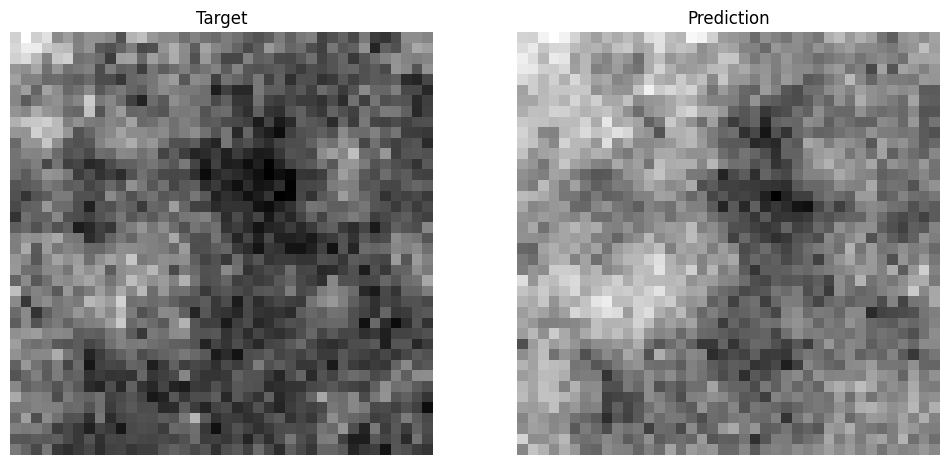

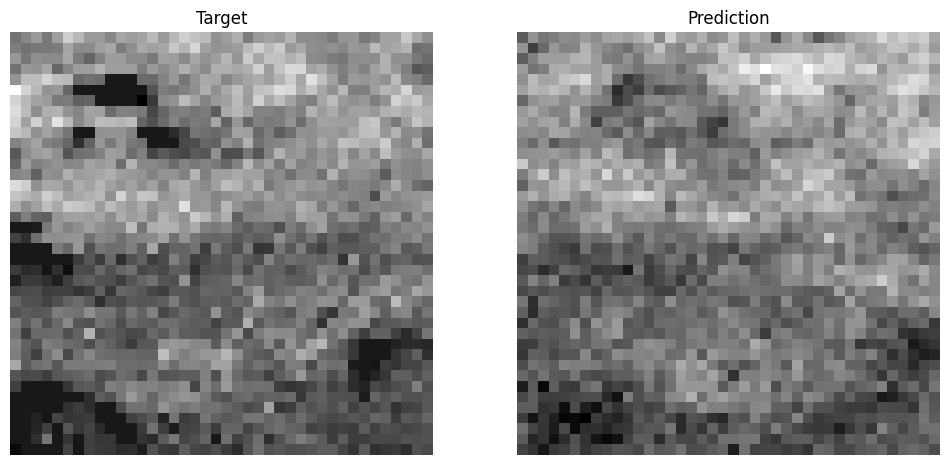

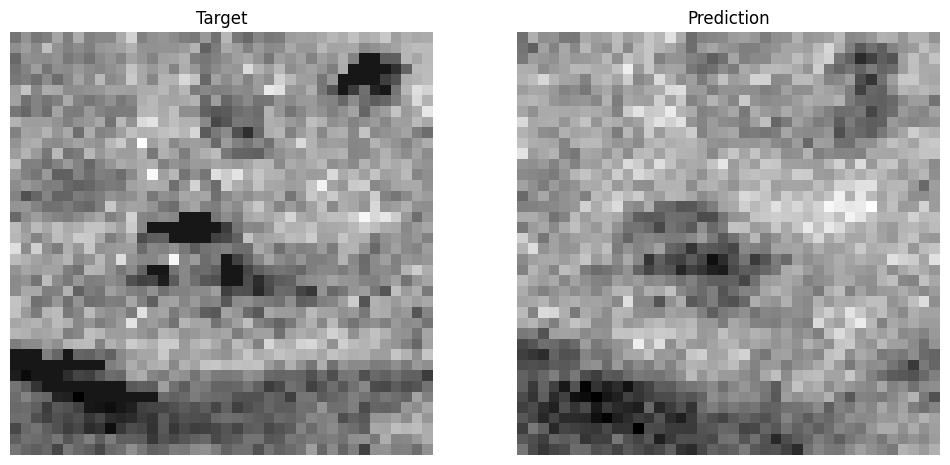

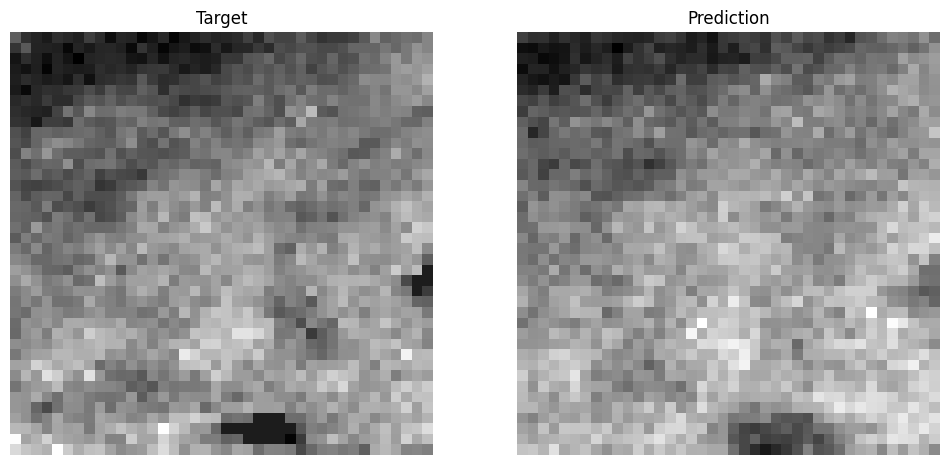

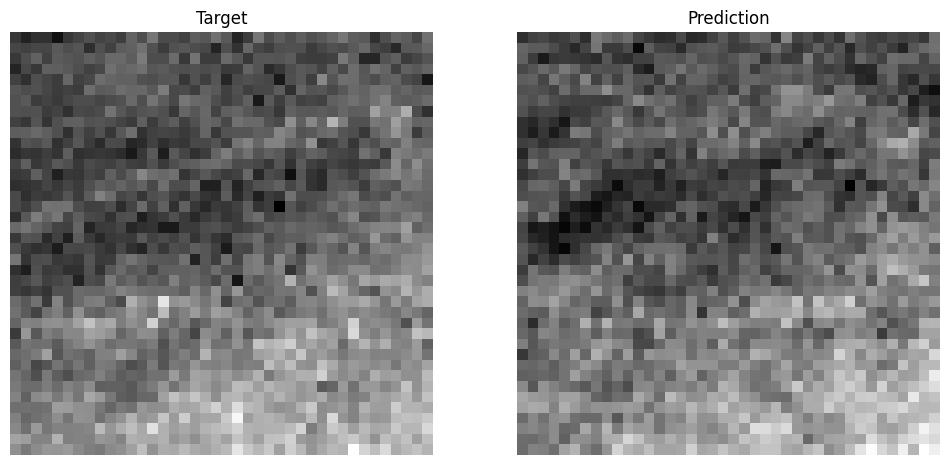

In [154]:
test_targets_np = test_targets.reshape(-1, 1, 40, 40)
test_predictions_np = test_predictions.reshape(-1, 1, 40, 40)

import matplotlib.pyplot as plt

def visualize_target_vs_prediction(targets, predictions, index):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(targets[index, 0, :, :], cmap='gray')
    axes[0].set_title('Target')
    axes[0].axis('off')

    axes[1].imshow(predictions[index, 0, :, :], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.show()

visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=5)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=20)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=4)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=16)
visualize_target_vs_prediction(test_targets_np, test_predictions_np, index=11)